In [1]:
# ! pip install pandas matplotlib scikit-learn xgboost numpy fastparquet pyarrow

In [2]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import precision_recall_fscore_support, f1_score, accuracy_score, hamming_loss
from sklearn.model_selection import train_test_split

from xgboost import XGBClassifier

# Import data

In [ ]:
df_train = pd.read_parquet("../data/processed/train_cleaned.parquet")  #
df_valid = pd.read_parquet("../data/processed/valid_cleaned.parquet")
df_test  = pd.read_parquet("../data/processed/test_cleaned.parquet")

In [4]:
TEXT_COL = "text_aggressive"

X_train = df_train[TEXT_COL]
X_valid = df_valid[TEXT_COL]
X_test  = df_test[TEXT_COL]

# Encoding

In [ ]:
tfidf = TfidfVectorizer(  
    ngram_range=(1, 2),  # Consider unigrams and bigrams (1-word and 2-word combinations) to capture more context
    max_features=10000,  #  Limit the vocabulary to the top 10,000 most frequent terms to reduce dimensionality
    min_df=5,   # Ignore terms that appear in fewer than 5 documents to remove rare noise
    max_df=0.95,   # Ignore terms that appear in more than 95% of documents to remove common stop words
    sublinear_tf=True, # Apply sublinear scaling to term frequencies 
    norm="l2"   # Normalize the vectors using L2 norm to ensure comparable magnitudes
)

In [6]:
X_train_tfidf = tfidf.fit_transform(X_train)
X_valid_tfidf = tfidf.transform(X_valid)
X_test_tfidf  = tfidf.transform(X_test)

# Training

In [8]:
def compute_scale_pos_weight(y: pd.Series) -> float:
    n_pos = (y == 1).sum()
    n_neg = (y == 0).sum()
    return n_neg / max(n_pos, 1)

In [9]:
LABELS = [
    "toxic",
    "severe_toxic",
    "obscene",
    "threat",
    "insult",
    "identity_hate"
]

models = {}

for label in LABELS:
    print(f"Training {label}")

    y_train = df_train[label]
    y_valid = df_valid[label]

    spw = compute_scale_pos_weight(y_train)  # scale positive weight

    model = XGBClassifier(
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        objective="binary:logistic",
        eval_metric="logloss",
        scale_pos_weight=spw,
        tree_method="hist",
        n_jobs=-1,
        random_state=42,
        early_stopping_rounds=20
    )

    model.fit(
        X_train_tfidf,
        y_train,
        eval_set=[(X_train_tfidf, y_train), (X_valid_tfidf, y_valid)],
        verbose=False
    )

    models[label] = model

Training toxic
Training severe_toxic
Training obscene
Training threat
Training insult
Training identity_hate


In [ ]:
for label, model in models.items():
    with open(f"../models/xgb_{label}.pth", "wb") as f:  #
        pickle.dump(model, f)

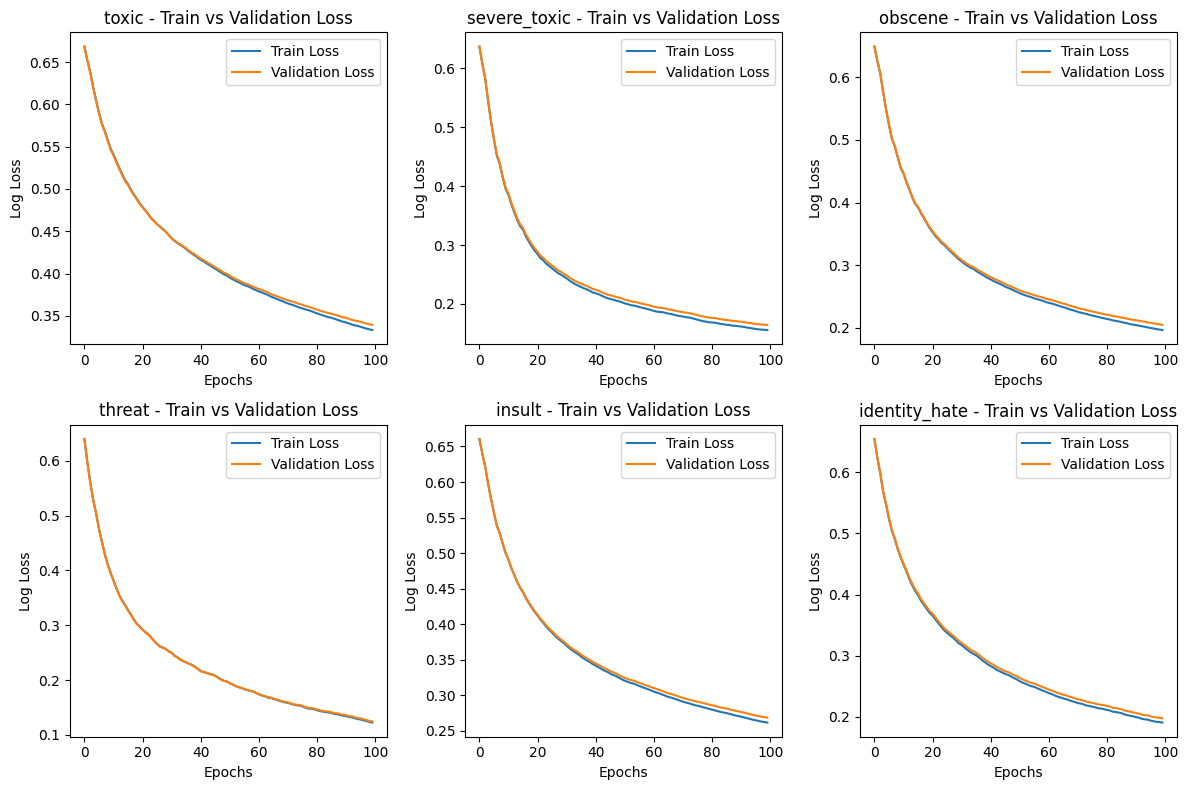

In [11]:
# Check for overfitting: Plot training vs validation loss curves
plt.figure(figsize=(12, 8))
for i, label in enumerate(LABELS):
    model = models[label]
    results = model.evals_result()
    epochs = len(results['validation_0']['logloss'])
    x_axis = range(0, epochs)
    
    plt.subplot(2, 3, i+1)
    plt.plot(x_axis, results['validation_0']['logloss'], label='Train Loss')
    plt.plot(x_axis, results['validation_1']['logloss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Log Loss')
    plt.title(f'{label} - Train vs Validation Loss')
    plt.legend()

plt.tight_layout()
plt.show()

# Prediction

In [12]:
def find_best_threshold(y_true, y_proba):
    thresholds = np.linspace(0.1, 0.9, 17)
    best_f1 = 0
    best_thresh = 0.5
    for thresh in thresholds:
        y_pred = (y_proba >= thresh).astype(int)
        f1 = f1_score(y_true, y_pred, average='binary', zero_division=0)
        if f1 > best_f1:
            best_f1 = f1
            best_thresh = thresh
    return best_thresh

best_thresholds = {}
for label in LABELS:
    y_valid = df_valid[label]
    y_proba_valid = models[label].predict_proba(X_valid_tfidf)[:, 1]
    best_thresh = find_best_threshold(y_valid, y_proba_valid)
    best_thresholds[label] = best_thresh
    print(f"Best threshold for {label}: {best_thresh:.2f}")

Best threshold for toxic: 0.60
Best threshold for severe_toxic: 0.90
Best threshold for obscene: 0.70
Best threshold for threat: 0.80
Best threshold for insult: 0.65
Best threshold for identity_hate: 0.90


# Evaluation

Validation Global Metrics:


,split,macro_f1,micro_f1,exact_accuracy,hamming_loss
0,valid,0.564219,0.699854,0.91076,0.021474


Validation Summary by Label:


,label,pos_rate_valid,precision,recall,f1
2,obscene,0.053331,0.810157,0.787309,0.798570
0,toxic,0.092373,0.789220,0.665536,0.722120
4,insult,0.048944,0.664766,0.746479,0.703257
1,severe_toxic,0.009087,0.342742,0.586207,0.432570
5,identity_hate,0.008272,0.417266,0.439394,0.428044
3,threat,0.002820,0.227273,0.444444,0.300752


Test Global Metrics:


,split,macro_f1,micro_f1,exact_accuracy,hamming_loss
0,test,0.555499,0.68569,0.903998,0.022893


Test Summary by Label:


,label,pos_rate_test,precision,recall,f1
2,obscene,0.051698,0.796341,0.791515,0.793921
0,toxic,0.096754,0.791894,0.658031,0.718783
4,insult,0.049442,0.623740,0.705957,0.662307
5,identity_hate,0.008522,0.427536,0.433824,0.430657
1,severe_toxic,0.009650,0.348936,0.532468,0.421594
3,threat,0.002632,0.208696,0.571429,0.305732


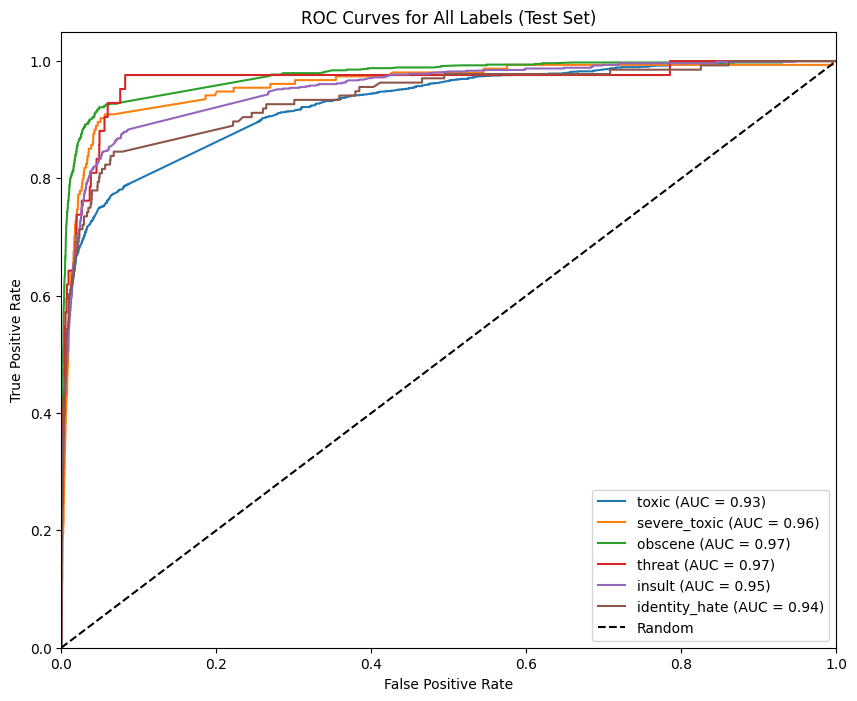

In [13]:
# VALIDATION with best thresholds
y_pred_valid = {}
y_proba_valid = {}
for label in LABELS:
    proba = models[label].predict_proba(X_valid_tfidf)[:, 1]
    y_proba_valid[label] = proba
    y_pred_valid[label] = (proba >= best_thresholds[label]).astype(int)

Y_true_valid = df_valid[LABELS].values
Y_pred_valid = np.column_stack([y_pred_valid[l] for l in LABELS])

global_metrics_valid = {
    "split": "valid",
    "macro_f1": f1_score(Y_true_valid, Y_pred_valid, average="macro", zero_division=0),
    "micro_f1": f1_score(Y_true_valid, Y_pred_valid, average="micro", zero_division=0),
    "exact_accuracy": accuracy_score(Y_true_valid, Y_pred_valid),
    "hamming_loss": hamming_loss(Y_true_valid, Y_pred_valid),
}

df_global_valid = pd.DataFrame([global_metrics_valid])

# Summary table for validation
rows_valid = []
for label in LABELS:
    y_true = df_valid[label].values
    y_pred = y_pred_valid[label]

    p, r, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average="binary", zero_division=0
    )

    rows_valid.append({
        "label": label,
        "pos_rate_valid": float(y_true.mean()),
        "precision": float(p),
        "recall": float(r),
        "f1": float(f1),
    })

results_valid_df = pd.DataFrame(rows_valid).sort_values("f1", ascending=False)

print("Validation Global Metrics:")
display(df_global_valid)
print("Validation Summary by Label:")
display(results_valid_df)

# TEST with best thresholds
y_pred_test = {}
y_proba_test = {}
for label in LABELS:
    proba = models[label].predict_proba(X_test_tfidf)[:, 1]
    y_proba_test[label] = proba
    y_pred_test[label] = (proba >= best_thresholds[label]).astype(int)

Y_true_test = df_test[LABELS].values
Y_pred_test = np.column_stack([y_pred_test[l] for l in LABELS])

global_metrics_test = {
    "split": "test",
    "macro_f1": f1_score(Y_true_test, Y_pred_test, average="macro", zero_division=0),
    "micro_f1": f1_score(Y_true_test, Y_pred_test, average="micro", zero_division=0),
    "exact_accuracy": accuracy_score(Y_true_test, Y_pred_test),
    "hamming_loss": hamming_loss(Y_true_test, Y_pred_test),
}

df_global_test = pd.DataFrame([global_metrics_test])

# Summary table for test
rows_test = []
for label in LABELS:
    y_true = df_test[label].values
    y_pred = y_pred_test[label]

    p, r, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average="binary", zero_division=0
    )

    rows_test.append({
        "label": label,
        "pos_rate_test": float(y_true.mean()),
        "precision": float(p),
        "recall": float(r),
        "f1": float(f1),
    })

results_test_df = pd.DataFrame(rows_test).sort_values("f1", ascending=False)

print("Test Global Metrics:")
display(df_global_test)
print("Test Summary by Label:")
display(results_test_df)

# ROC Curves for all labels in one figure
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(10, 8))
for label in LABELS:
    fpr, tpr, _ = roc_curve(df_test[label], y_proba_test[label])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{label} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for All Labels (Test Set)')
plt.legend(loc="lower right")
plt.show()